# Market Risk Project 2025/2026
Authored by **Axel Portier** and **Gaspard Salluron--Besnard** as part of our Market Risk course

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [154]:
df=pd.read_csv('natixis_stock.txt', sep="\t", names=["date", "price"])
df["price"]=df["price"].str.replace(',','.').astype(float)
df["date"]=pd.to_datetime(df["date"], format="%d/%m/%Y")
df["price"] = pd.to_numeric(df["price"], errors="coerce")

print(df.head())
effectif_tot = len(df)
print("\nEffectif:", effectif_tot)


        date  price
0 2015-01-02  5.621
1 2015-01-05  5.424
2 2015-01-06  5.329
3 2015-01-07  5.224
4 2015-01-08  5.453

Effectif: 1023


# Question A (Ex2, part of Q1 and of Q2 of TD1)


#### a – From the time series of the daily prices of the stock Natixis between January 2015 and December 2016, provided with TD1, estimate a historical VaR on price returns at a one-day horizon for a given probability level (this probability is a parameter which must be changed easily). 
#### You must base your VaR on a non-parametric distribution biweight Kernel. That is 𝐾 is the derivative of the logistic function :$$ x \mapsto \frac{15}{16}(1-x^2)^2 \mathbf{1}_{|x| \le 1}$$

### The cdf estimated is then :
$$\hat{F}(x) = \frac{1}{n} \sum_{i=1}^{n} G\left(\frac{x - R_i}{h}\right)$$

#### Where $G(u)$ is the primitive of the Kernel $K(u)$ :
$$G(u) = \int_{-1}^{u} K(x) dx$$
$$\iff G(u) = \int_{-1}^{u} \frac{15}{16}(1-x^2)^2 dx$$

#### In developping the polynom $(1-x^2)^2 = 1 - 2x^2 + x^4$, we obtain for $u \in [-1, 1]$ :
$$G(u) = \frac{3}{16}u^5 - \frac{5}{8}u^3 + \frac{15}{16}u + \frac{1}{2}$$

### Finally, 
$$\hat{F}(\text{VaR}_\alpha) = P( Rt <= \text{VaR}_\alpha) = \alpha $$

In [6]:
df_qA = df[(df["date"] >= "2015-01-01") & (df["date"] < "2017-01-01")].copy()
df_qA["return"] = df_qA["price"].pct_change()
df_qA=df_qA.dropna()
df_qA.sort_values(by="return", ascending = True)
returns = df_qA["return"].values

effectif_A = len(returns)
print("\nEffectif:", effectif_A)

methods_bandwidths = {
    "Under Smoothing" : 0.79 * np.std(returns) * (effectif_A**(-1/5)),
    "Silverman": 1.06 * np.std(returns) * (effectif_A ** (-1/5)),
    "Over Smoothing" : 1.144 * np.std(returns) * (effectif_A**(-1/5)),
    "Scott": 3.5 * np.std(returns) * (effectif_A**(-1/3))
}

epsilon = 1e-10


Effectif: 512


In [7]:
def K(u):
    abs_u = np.abs(u)
    mask = abs_u <= 1
    return (15/16) * (1 - u**2)**2 * mask
    
def kernel_density(x, R, h):
    n = len(R)
    u = (x - R) / h
    kde = np.sum(K(u)) / (n * h)
    return kde

def G(x):
    if x>=1 :
        return 1
    elif x< -1 :
        return 0
    else :
        return (3/16)*x**5+(5/8)*x**3-(15/16)*x+0.5

def cdf_estimate(x, R, h):
    total = 0
    for i in range(len(R)):
        total += G((x - R[i]) / h)
    return total/len(R)

def dich(R,eps,alph, h):
    a = min(R)
    b = max(R)
    m=(a+b)/2
    F = cdf_estimate(m, R, h)
    while abs(b-a) > eps:        
        if F > alph:
            b=m
        else:
            a=m
        m=(a+b)/2
        F = cdf_estimate(m, R, h)
    return m

alpha = float(input("alpha error (ex 5%)")) * 0.01
VaR = {}

for name,h in methods_bandwidths.items() :
    VaR_npar_qA = dich(returns, epsilon, alpha, h)
    VaR[name] = VaR_npar_qA
    print(f"\n -VaR {int(100-alpha*100)}% 1 day horizon = {VaR_npar_qA:.4f} ({VaR_npar_qA*100:.2f}%) with {name} bandwidth (h={h:.3f})")


 -VaR 95% 1 day horizon = -0.0393 (-3.93%) with Under Smoothing bandwidth (h=0.005)

 -VaR 95% 1 day horizon = -0.0399 (-3.99%) with Silverman bandwidth (h=0.007)

 -VaR 95% 1 day horizon = -0.0405 (-4.05%) with Over Smoothing bandwidth (h=0.008)

 -VaR 95% 1 day horizon = -0.0424 (-4.24%) with Scott bandwidth (h=0.010)


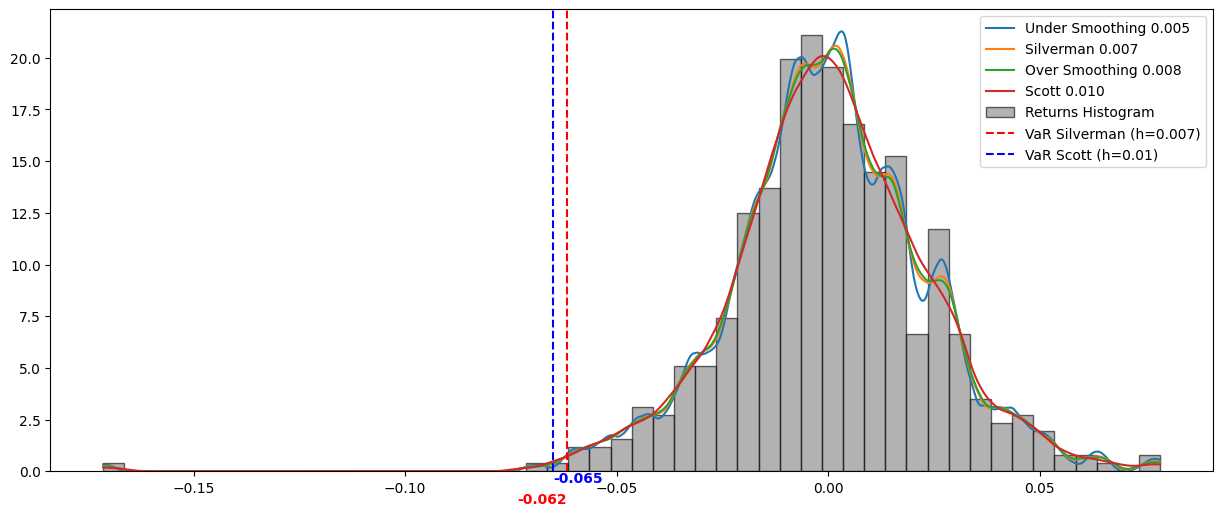

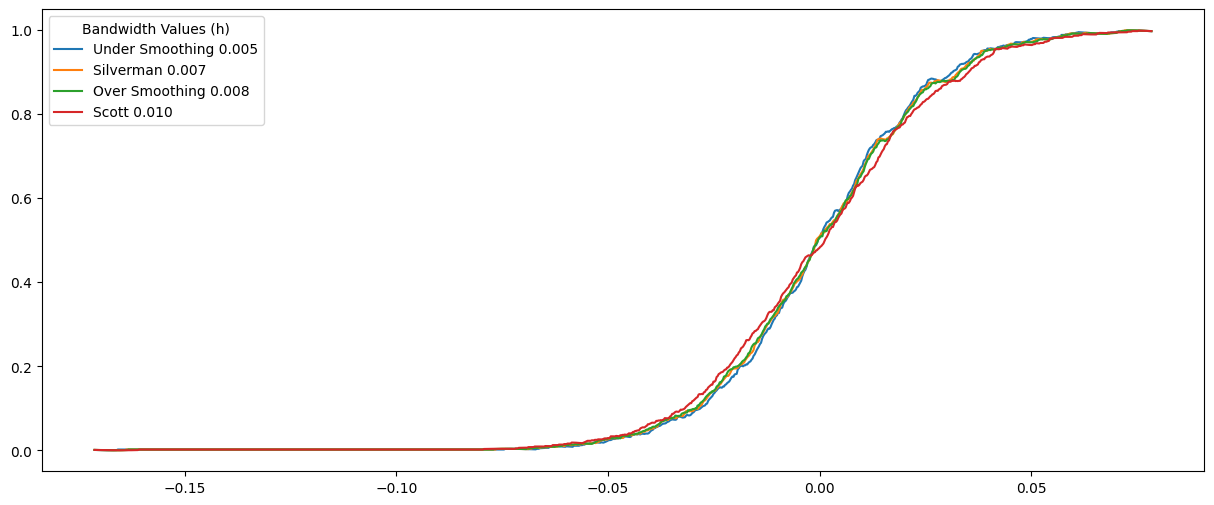

In [252]:
plt.figure(figsize=(15, 6))
x = np.linspace(min(returns), max(returns), 1000)
for name,h in methods_bandwidths.items() :
    y = [kernel_density(i, returns, h) for i in x]
    plt.plot(x,y, label = f"{name} {h:.3f}")
plt.hist(returns, bins=50, density=True, alpha=0.6, color='gray', edgecolor='black', label='Returns Histogram')

plt.axvline(x=VaR["Silverman"], color='red', linestyle='--', label='VaR Silverman (h=0.007)')
plt.axvline(x=VaR["Scott"], color='blue', linestyle='--', label='VaR Scott (h=0.01)')
plt.text(VaR["Scott"], 0, f'{VaR["Scott"]:.3f}', color='blue', 
         ha='left', va='top', fontweight='bold')
plt.text(VaR["Silverman"], -1, f'{VaR["Silverman"]:.3f}', color='red', 
         ha='right', va='top', fontweight='bold')
plt.legend()

plt.figure(figsize=(15, 6))
x = np.linspace(min(returns), max(returns), 1000)
for name,h in methods_bandwidths.items() :
    y = [cdf_estimate(i, returns, h) for i in x]
    plt.plot(x,y, label = f"{name} {h:.3f}")
plt.legend(title='Bandwidth Values (h)')

From the plot, we can clearly see that the estimated density depends strongly on the choice of the bandwidth ℎ.
All curves are **centered** around zero and follow the general shape of the **returns histogram**, but they differ in how **smooth** they are and how much detail they capture.

- **With a smaller bandwidth (h = 0.005)**, the density is much more irregular. This suggests under-smoothing, where **noise is captured as structure**.
- **As the bandwidth increases (Silverman and h = 0.008)**, the curves become **smoother** and more **stable**.
- **Using Scott’s rule (h = 0.010)** results in the smoothest curve, which highlights the overall shape but tends to **flatten** local variations, especially in the **tails**.

We clearly see that the two bandwidths (Scott and Silvermann) produce different VaR values: one is more pessimistic than the other, simply due to a different level of smoothing. Finally with h increasing, the smoothing is higher but the VaR si then more pessimistic.

#### b – Which proportion of price returns between January 2017 and December 2018 does exceed the VaR threshold defined in the previous question? 
#### Do you validate the choice of this non-parametric VaR?

In [ ]:
df_new = df[(df["date"] >= "2017-01-01") & (df["date"] < "2019-01-01")].copy()
df_new["return"] = df_new["price"].pct_change()
df_new=df_new.dropna()

effectif_new = len(returns)
print("\nEffectif:", effectif_new)

for name in methods_bandwidths.keys() :
    print(f"\n -{name}'s bandwidth : {(len(df_new[df_new["return"]<=VaR[name]])/effectif_new)*100:.3f}% return exceed VaR (95% confidence)")


Effectif: 509

 -Under Smoothing's bandwidth : 1.572% return exceed VaR (95% confidence)

 -Silverman's bandwidth : 1.572% return exceed VaR (95% confidence)

 -Over Smoothing's bandwidth : 1.572% return exceed VaR (95% confidence)

 -Scott's bandwidth : 1.375% return exceed VaR (95% confidence)


According to the results, the percentage of returns exceeding the VaR 95% threshold is below the 5% limit for all four methods. This **validates** that our non-parametric Kernel VaR approach is appropriate and sufficiently conservative for this dataset.

To go further, we should perform a backtesting analysis and that values crossing the threshold aren't forming **clusters**. We need to ensure that those exceeding are independant

# Question B (Ex2, Q5 of TD2)
#### Calculate the expected shortfall for the VaR calculated in question A.
#### How is the result, compared to the VaR?

In [263]:
ES = {}
for name in methods_bandwidths.keys() :
    expected_shortfall = df_qA[df_qA["return"]<=VaR[name]]["return"].mean()
    ES[name] = expected_shortfall
    print(f"\n -{name}'s bandwidth : {expected_shortfall*100:.2f}% ES (correspondant VaR: {VaR[name]*100:.2f}%)")


 -Under Smoothing's bandwidth : -5.60% ES (correspondant VaR: -3.92%)

 -Silverman's bandwidth : -5.60% ES (correspondant VaR: -3.96%)

 -Over Smoothing's bandwidth : -5.60% ES (correspondant VaR: -4.04%)

 -Scott's bandwidth : -5.74% ES (correspondant VaR: -4.24%)


Text(0.5, 1.0, 'Density kernel for VaR 95% and its corresponding expected shortfall with Silverman bandwidth')

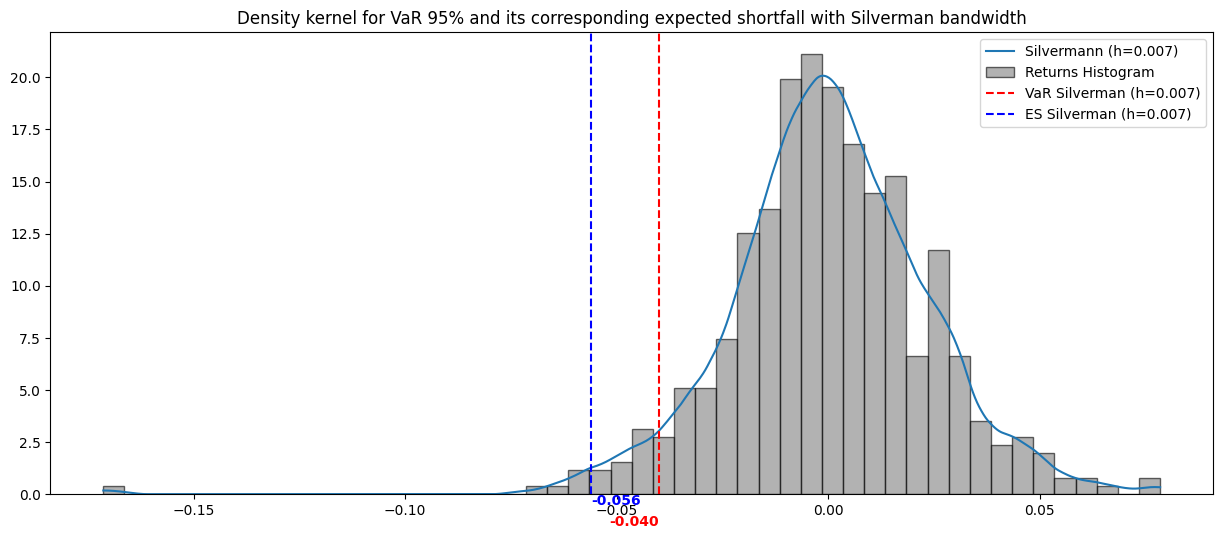

In [21]:
x = np.linspace(min(returns), max(returns), 1000)
y = [kernel_density(i, returns, h) for i in x]

plt.figure(figsize=(15, 6))
plt.plot(x,y, label = "Silvermann (h=0.007)")
plt.hist(returns, bins=50, density=True, alpha=0.6, color='gray', edgecolor='black', label='Returns Histogram')

plt.axvline(x=VaR["Silverman"], color='red', linestyle='--', label='VaR Silverman (h=0.007)')
plt.axvline(x=ES["Silverman"], color='blue', linestyle='--', label='ES Silverman (h=0.007)')
plt.text(ES["Silverman"], 0, f'{ES["Silverman"]:.3f}', color='blue', 
         ha='left', va='top', fontweight='bold')
plt.text(VaR["Silverman"], -1, f'{VaR["Silverman"]:.3f}', color='red', 
         ha='right', va='top', fontweight='bold')

plt.legend()
plt.title('Density kernel for VaR 95% and its corresponding expected shortfall with Silverman bandwidth')

We see clearly that our expected shortfalls, no matter the method of the bandwidth, are larger than the VaR. It is perfectly coherent as the expected shortfall is defined as the average occuring beyond the VaR threshold. So our results confirm the consistency of the non parametric model.

# Question C (Ex2, Q1 and Q2 of TD3)
With the dataset provided for TD1 on Natixis prices, first calculate daily returns. You will then analyse
these returns using a specific method in the field of the EVT.

In [155]:
df["return"] = df["price"].pct_change()
X_losses = df[df["return"]<0]["return"]
X_losses = (-X_losses).copy()
n_losses = len(X_losses)
X_gain = df[df["return"]>=0]["return"].copy()
n_gain = len(X_gain)

print("Number of losses :",n_losses)
print("Number of gain :",n_gain)

Number of losses : 519
Number of gain : 503


#### a – Estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of Pickands. 
#### What can you conclude about the nature of the extreme gains and losses?

Let $(X_n)_{n \geq 1}$ be a sequence of **i.i.d.** random variables, whose cumulative distribution function $F$ belongs to the **max-domain of attraction** of a Generalized Extreme Value (**GEV**) distribution with shape parameter $\xi \in \mathbb{R}$.

Let $k(n)$ be a function $\mathbb{N} \to \mathbb{N}$. If:
$$\lim_{n \to \infty} k(n) = \infty \quad \text{and} \quad \lim_{n \to \infty} \frac{k(n)}{n} = 0$$

Then, the **Pickands estimator**, defined by:
$$\hat{\xi}_{k(n),n}^{P} = \frac{1}{\log(2)} \log \left( \frac{X_{n-k(n)+1:n} - X_{n-2k(n)+1:n}}{X_{n-2k(n)+1:n} - X_{n-4k(n)+1:n}} \right)$$

converges in **probability** to $\xi$:
$$\hat{\xi}_{k(n),n}^{P} \xrightarrow{P} \xi \quad \text{as} \quad n \to \infty$$

Moreover, if:
$$\lim_{n \to \infty} \frac{k(n)}{\log(\log(n))} = \infty$$

then the convergence of $\hat{\xi}_{k(n),n}^{P}$ towards $\xi$ is **almost sure** ($a.s.$) and not only in probability.

In [ ]:
def root(x): 
    return np.sqrt(x)
def log(x): 
    return np.log(x)

def pickands_estimator(X, k):
    k=int(k) # need an integer as k will represent a list's index
    X = X.sort_values(ascending=True)
    n = len(X)
    
    if 4*k >= n:  # validity condtion as n-4*k>=0 and n-2*k>=0 
        return np.nan
    
    num = X.iloc[n-k] - X.iloc[n-2*k] # Pas de "+1" comme dans le cours car en python les indices commencent à 0 
    denom = X.iloc[n-2*k] - X.iloc[n-4*k]

    return (1/np.log(2)) * np.log(num/denom)

To ensure the convergence of the Pickands estimator $\hat{\xi}_{k(n),n}^{P}$, the sequence $k(n)$ must satisfy specific growth conditions relative to the sample size $n$. We have chosen to test two classic functions, **Logarithmic** and **Square Root**, because they both respect the required asymptotic behavior:

1. **Logarithmic Function**: $k(n) = \lfloor \ln(n) \rfloor$ satisfying:
   $$\lim_{n \to \infty} \ln(n) = \infty \quad \text{and} \quad \lim_{n \to \infty} \frac{\ln(n)}{n} = 0$$

2. **Square Root Function**: $k(n) = \lfloor \sqrt{n} \rfloor$ satisfying:
   $$\lim_{n \to \infty} \sqrt{n} = \infty \quad \text{and} \quad \lim_{n \to \infty} \frac{\sqrt{n}}{n} = 0$$

In [157]:
print(f"-Pickands estimator of losses (log) = {pickands_estimator(X_losses, log(n_losses)):.3f} for k = {int(log(n_losses))}")
print(f"-Pickands estimator of losses (root) = {pickands_estimator(X_losses, root(n_losses)):.3f} for k = {int(root(n_losses))}")

print(f"\n-Pickands estimator of gain (log) = {pickands_estimator(X_gain, log(n_gain)):.3f} for k = {int(log(n_gain))}")
print(f"-Pickands estimator of gain (root) = {pickands_estimator(X_gain, root(n_gain)):.3f} for k = {int(root(n_gain))}")

-Pickands estimator of losses (log) = -0.509 for k = 6
-Pickands estimator of losses (root) = 0.408 for k = 22

-Pickands estimator of gain (log) = 0.577 for k = 6
-Pickands estimator of gain (root) = 0.720 for k = 22


The fact that these two valid functions return opposite signs for the shape parameter $\xi$ of the losses highlights the **instability** of the estimator. While both $k(n)$ functions are theoretically "convergent" at infinity, they clearly fail to provide a stable estimate on our finite sample. 

Therefore, I will **delve deeper** into the analysis by plotting the estimator for all $k \in [5, n/4]$ to identify a true **stability**.

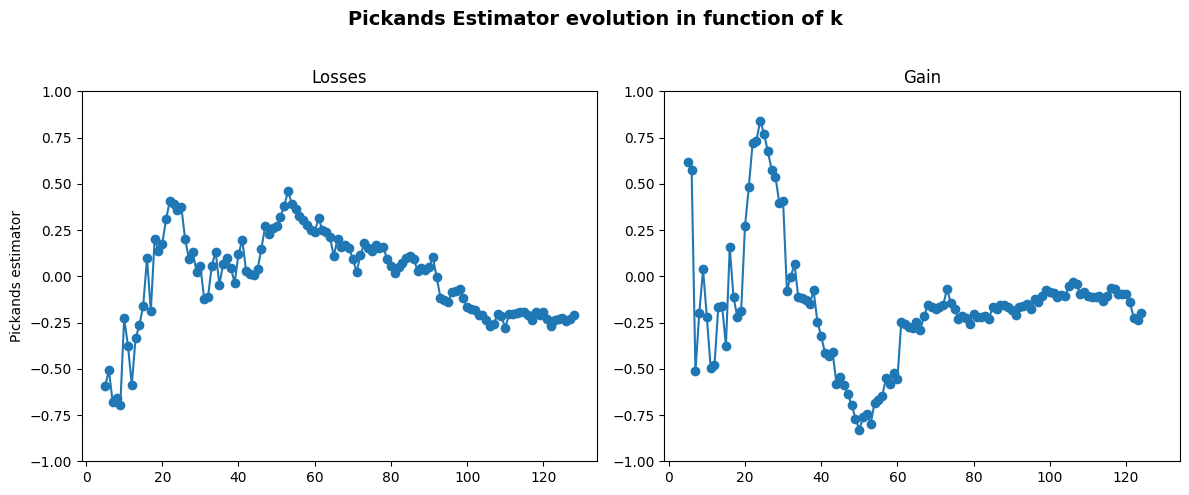

In [158]:
K_losses = range(5, n_losses//4)  # k doit être < n/4
K_gain = range(5, n_gain//4)

values_loss = [pickands_estimator(X_losses,k) for k in K_losses]
values_gain = [pickands_estimator(X_gain,k) for k in K_gain]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axes[0].plot(K_losses, values_loss, marker="o")
axes[0].set_title("Losses")
axes[0].set_ylabel("Pickands estimator")
axes[0].set_ylim(-1, 1)

axes[1].plot(K_gain, values_gain, marker="o")
axes[1].set_title("Gain")
axes[1].set_ylim(-1, 1)

plt.suptitle("Pickands Estimator evolution in function of k", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Based on the generated Pickands plots, we can draw the following conclusions regarding the stability of the estimator $\hat{\xi}^P$:

* **Overall Instability**: The curves exhibit significant volatility, particularly for **small values of $k$** ($k < 20$). This confirms that the estimator is highly sensitive to the sample's noise in the extreme tail, leading to unreliable results for low thresholds.
* **Analysis of Losses**: For the loss distribution, the estimator appears relatively stable within the range **$k \in [20, 80]$**. However, we observe a notable **spike around $k \approx 55$**, suggesting a local irregularity in the data that could bias the estimation if that specific threshold is chosen.
* **Analysis of Gains**: The behavior for gains is more robust. A **stability plateau** emerges near **$k \approx 60$** and extends smoothly without major spikes. Consequently, a threshold $k$ selected between **60 and 120** appears consistent and reliable for estimating the tail index of the gains.

**Conclusion for VaR Calculation**:  
The choice of $k$ is a classic trade-off between **bias** (high $k$) and **variance** (low $k$). Given these observations, we will select an "efficient $k$" within these identified plateaus to perform the final **Value-at-Risk (VaR)** .   

**k=25 for the losses and 70 for the gain**

#### b – Calculate the value at risk based on EVT for various confidence levels, with the assumption of iid returns.

$$VaR(p) = \frac{\left( \frac{k}{n(1-p)} \right)^{\xi^P} - 1}{1 - 2^{-\xi^P}} (X_{n-k+1:n} - X_{n-2k+1:n}) + X_{n-k+1:n}$$

Where:
* **$\xi^P$**: Is the Pickands estimator of the GEV parameter.
* **$n$**: Total number of observations.
* **$p$**: Confidence level (e.g., $0.99$).
* **$k$**: The chosen threshold (number of upper order statistics).
* **$X_{n-k+1:n}$**: The $(k)$-th largest observation.

In [186]:
def Pickands_VaR(X, k, alpha):
    X = X.sort_values(ascending = True)
    n = len(X)
    xi = pickands_estimator(X,k)
    num = (k/(n*(1-alpha)))**xi
    denom = 1-2**(-xi)
    return ((num-1)/denom)*(X.iloc[n-k]-X.iloc[n-2*k])+X.iloc[n-k]

alphas = [0.90, 0.95, 0.975, 0.99, 0.995, 0.999]
k_gain = 70
k_loss = 25

ksi_gain = pickands_estimator(X_gain,k_gain)
ksi_losses = pickands_estimator(X_losses,k_loss)
print(f"EVT Parameter (losses): {ksi_losses:.3f} | EVT Parameter (gains): {ksi_gain:.3f}")

EVT Parameter (losses): 0.374 | EVT Parameter (gains): -0.175


In [166]:
for alpha in alphas:
    var_pick_gain = Pickands_VaR(X_gain, k_gain, alpha)
    var_pick_loss = Pickands_VaR(X_losses, k_loss, alpha)
    print(f"\n-Pickands VaR at alpha={alpha:.3f} Loss = {var_pick_loss:.4%} and Gain = {var_pick_gain:.4%})")


-Pickands VaR at alpha=0.900 Loss = 3.1332% and Gain = 3.2858%)

-Pickands VaR at alpha=0.950 Loss = 4.3796% and Gain = 4.0452%)

-Pickands VaR at alpha=0.975 Loss = 5.9953% and Gain = 4.7180%)

-Pickands VaR at alpha=0.990 Loss = 8.8880% and Gain = 5.4909%)

-Pickands VaR at alpha=0.995 Loss = 11.8394% and Gain = 5.9987%)

-Pickands VaR at alpha=0.999 Loss = 22.5151% and Gain = 6.9652%)


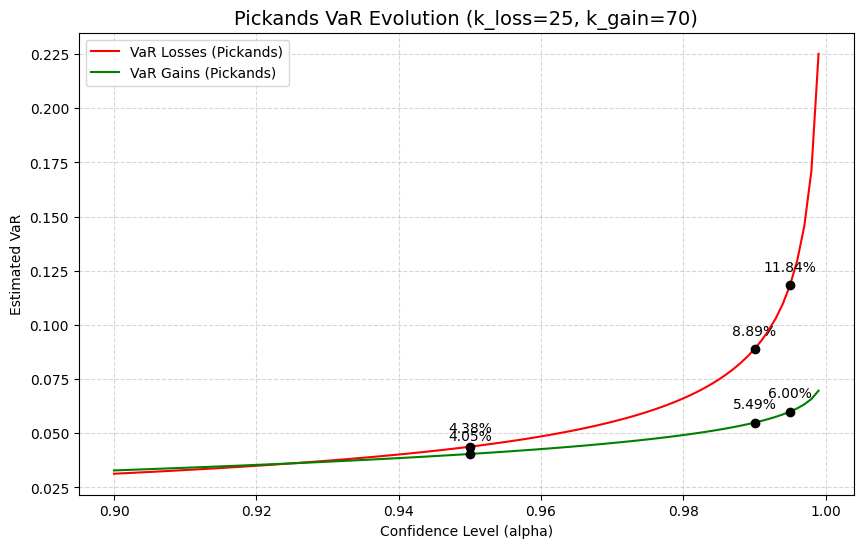

In [175]:
alpha_range = np.linspace(0.90, 0.999, 100)

var_losses = [Pickands_VaR(X_losses, k_loss, a) for a in alpha_range]
var_gains = [Pickands_VaR(X_gain, k_gain, a) for a in alpha_range]

plt.figure(figsize=(10, 6))
plt.plot(alpha_range, var_losses, label='VaR Losses (Pickands)', color='red')
plt.plot(alpha_range, var_gains, label='VaR Gains (Pickands)', color='green')

plt.title(f"Pickands VaR Evolution (k_loss={k_loss}, k_gain={k_gain})", fontsize=14)
plt.xlabel("Confidence Level (alpha)")
plt.ylabel("Estimated VaR")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

for a in [0.95, 0.99, 0.995]:
    val = Pickands_VaR(X_losses, k_loss, a)
    plt.scatter(a, val, color='black', zorder=5)
    plt.annotate(f'{val:.2%}', (a, val), textcoords="offset points", xytext=(0,10), ha='center')
    val = Pickands_VaR(X_gain, k_gain, a)
    plt.scatter(a, val, color='black', zorder=5)
    plt.annotate(f'{val:.2%}', (a, val), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

We analyze the evolution of the **Pickands VaR** across different confidence levels $\alpha$. This approach allows us to visualize the model's behavior in the **extreme tail** (from $90\%$ up to $99.9\%$).

* **Extreme Tail Asymmetry**: While both curves follow a similar path for $\alpha < 0.95$, they diverge significantly in the extreme tail. The **Losses (red curve)** exhibit a much steeper, nearly exponential slope compared to the **Gains (green curve)**.   

* **Quantitative Gap**: At the extreme $\alpha = 0.995$ level, the estimated VaR for losses reaches **11.84%**, which is nearly **double** the **6.00%** observed for gains. This gap quantifies the "asymmetry of fear" in the market.

# Question D (Ex2, Q5 of TD4)

In [87]:
df = pd.read_excel("Dataset TD4.xlsx")

#We replace commas with dots in object columns and convert to float
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float, errors='ignore')

df.rename(columns={'transaction date (1=1day=24 hours)': 'Date',
                   'bid-ask spread': 'Spread',
                   'volume of the transaction (if known)': 'Volume',
                   'Sign of the transaction': 'Sign',
                   'Price (before transaction)': 'Price'}, inplace=True)

df["Return"] = df["Price"].pct_change()

print(df.head())
print(df.isna().sum())
print(len(df))

results = []

       Date  Spread  Volume  Sign    Price    Return
0  0.000202  0.1100     8.0    -1  100.000       NaN
1  0.004074  0.1294    32.0     1  100.164  0.001640
2  0.014393  0.1141     8.0    -1  100.048 -0.001158
3  0.022861  0.0978   141.0    -1   99.876 -0.001719
4  0.037864  0.1291   121.0    -1   99.608 -0.002683
Date        0
Spread      0
Volume    688
Sign        0
Price       0
Return      1
dtype: int64
820


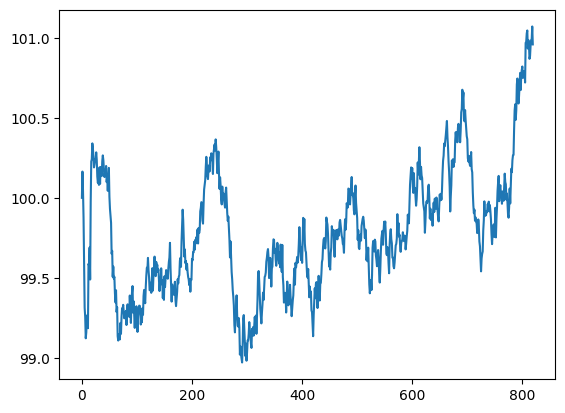

In [27]:
plt.plot(df.index,df["Price"])

820
Date      0
Spread    0
Volume    0
Sign      0
Price     0
Return    0
dtype: int64
131


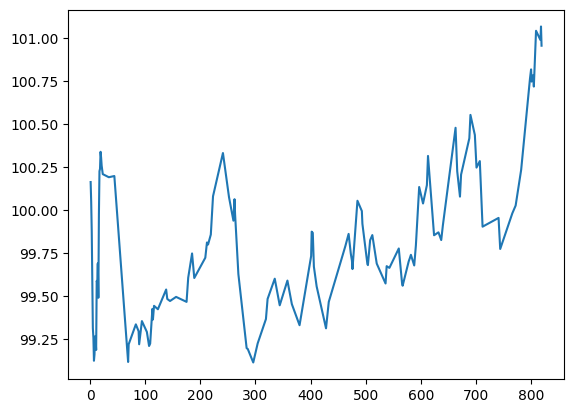

In [88]:
print(len(df))
df.dropna(inplace=True)
print(df.isna().sum())
print(len(df))

plt.plot(df.index,df["Price"])

By dropping the rows where the transaction's volume are **empty** we see that the initial **shape** is conserv so we must not loose the main informations of the time serie.

#### With the dataset and the framework provided for TD4, estimate all the parameters of Bouchaud's price impact model. 
#### Comment the obtained values. Is this model well specified?

### **Transitory Impact Model (Bouchaud)**

The current price $p_t$ is modeled as the sum of past transaction impacts:

$$p_t = p_{-\infty} + \sum_{s=-\infty}^{t-1} G(t - s) \varepsilon_s S_s V_s^r$$

#### **Parameters Explanation:**

* **$p_t$**: Current price at time $t$.
* **$p_{-\infty}$**: Fundamental price (initial price before impact).
* **$G(t - s)$**: is a function worth 0 on R-, which can be interpreted as the impact of a single order. A statistical study on long-term correlation can allow this function to be fixed, in the form, for example, of a decreasing power function
* **$\varepsilon_s$**: **Sign** is -1 or 1 depending on whether the transaction is a buy (price = ask) or a sell
(price = bid) on the market;
* **$S_s$**: **Spread** at the time of transaction $s$.
* **$V_s^r$**: **Volume** of the transaction, with r close to zero to have a concave function
of the volume;
represents the **concavity** of the impact.

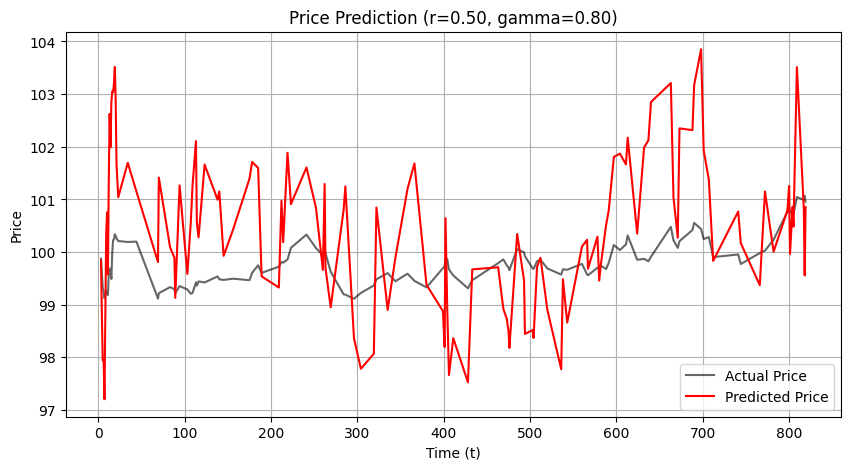

In [89]:
best_r, best_gamma = (0.5, 0.8)
p0 = df["Price"].iloc[0]
T_max = len(df)
impacts = df["Sign"] * df["Spread"] * (df["Volume"]**best_r)
final_preds = []

for T in range(2, T_max):
    x_t = sum(((T-t)**-best_gamma) * impacts.iloc[t] for t in range(1, T))
    final_preds.append(p0 + x_t)

plt.figure(figsize=(10, 5))

plt.plot(df.index[2:T_max], df["Price"].iloc[2:T_max], label="Actual Price", color="black", alpha=0.6)

plt.plot(df.index[2:T_max], final_preds, label="Predicted Price", color="red")

plt.title(f"Price Prediction (r={best_r:.2f}, gamma={best_gamma:.2f})")
plt.xlabel("Time (t)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Test r =0.5 and gamma approx 0.8 according to Papers but the result are not convaincant

Now we are going to estimate those parameters doing a GridSearch, minimizing the MSE :

\begin{equation}
    MSE(r;\gamma) = \frac{1}{N} \sum_{i=1}^{N} (P_i - \hat{P}^B_i(r;\gamma))^2
\end{equation}

With $\hat{P}^B_i$ being the **Bouchaud Price** predicted by the model:
\begin{equation}\hat{P}^B_i(r;\gamma) = P_0 + \sum_{s=1}^{i-1} (i - s)^{-\gamma} \varepsilon_s S_s V_s^r\end{equation}

### Test a grid search for both parameters

In [90]:
def grid_search(data, grid_r, grid_gamma):
    preds = []
    true = []
    p0 = data["Price"].iloc[0]
    best_mse = np.inf
    best_params = ()

    for r in grid_r:
        for gamma in grid_gamma:
            
            for T in range(2, len(data)):

                impacts = 0
                for t in range(1, T):
                    impacts += data["Sign"].iloc[t] * data["Spread"].iloc[t] * (data["Volume"].iloc[t]**r) * (T - t)**(-gamma)
                
                p_hat = p0 + impacts
                preds.append(p_hat)
                true.append(data["Price"].iloc[T])

            mse = np.mean((np.array(true) - np.array(preds))**2)

            if mse < best_mse:
                best_mse = mse
                best_params = (r, gamma, mse)             
                #{"r": r, "gamma": gamma, "mse": mse}

    return best_params

grid_r = np.arange(0.1, 0.9, 0.05)
grid_g = np.arange(0.1, 0.9, 0.05)

best_param_grid = grid_search(df, grid_r, grid_g)
print(best_param_grid)

results.append({
    "Method": " Grid_Search",
    "r": best_param_grid[0],
    "gamma": best_param_grid[1],
    "MSE": best_param_grid[2]
})

(0.1, 0.8500000000000002, 0.3650177906688251)


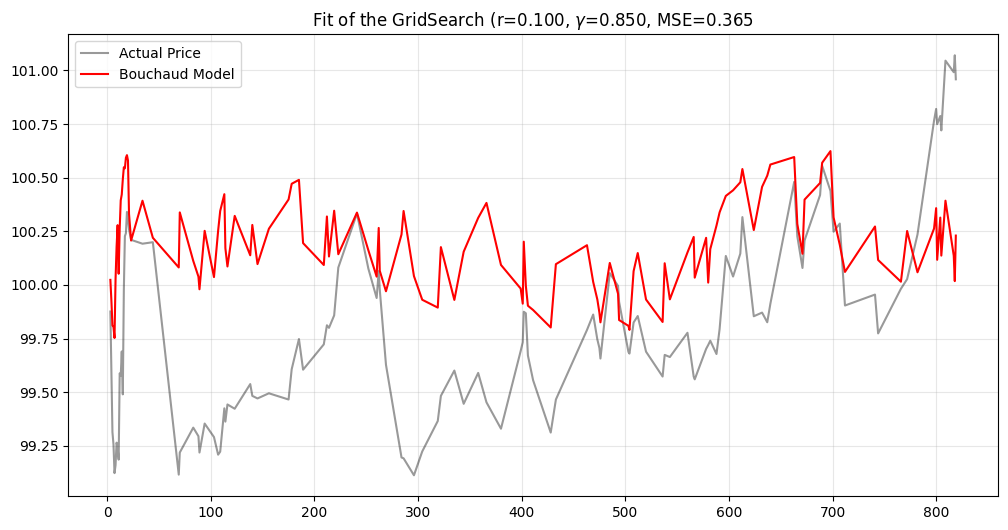

In [91]:
best_r, best_gamma, mse = best_param_grid
p0 = df["Price"].iloc[0]
T_max = len(df)

impacts = df["Sign"] * df["Spread"] * (df["Volume"]**best_r)

final_preds = []

for T in range(2, T_max):
    x_t = sum(((T - t)**-best_gamma) * impacts.iloc[t] for t in range(1, T))
    final_preds.append(p0 + x_t)

plt.figure(figsize=(12, 6))

plt.plot(df.index[2:T_max], df["Price"].iloc[2:T_max], label="Actual Price", color="black", alpha=0.4)
plt.plot(df.index[2:T_max], final_preds, label="Bouchaud Model", color="red", linewidth=1.5)

plt.title(fr"Fit of the GridSearch (r={best_r:.3f}, $\gamma$={best_gamma:.3f}, MSE={mse:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Trying a different method : the Gradient Descent, minimizing the MSE convexe function with r and $\gamma$ parameters 

In [92]:
def get_mse(data, r, gamma):
    pred = []
    price_true = []
    p0 = data["Price"].iloc[0]

    for T in range(2,len(data)):
        impacts = 0
        for t in range(1,T):
            tau = T - t
            impacts += data["Sign"].iloc[t] * data["Spread"].iloc[t] * (data["Volume"].iloc[t]**r) * tau**(-gamma)
        pred.append(p0 + impacts)
        price_true.append(data["Price"].iloc[T])

    return np.mean((np.array(pred)-np.array(price_true))**2)

def get_gradient(data, r, gamma, eps=1e-5):
    current_mse = get_mse(data, r, gamma)
    
    mse_r_plus = get_mse(data, r + eps, gamma)
    grad_r = (mse_r_plus - current_mse) / eps

    mse_g_plus = get_mse(data, r, gamma + eps)
    grad_g = (mse_g_plus - current_mse) / eps
    
    return grad_r, grad_g

def gradient_descent(data, learning_rate, max_iter,r,gamma):
    best_mse = np.inf
    iter = 0
    best_params = ()

    while iter < max_iter :
        grad_r, grad_gamma = get_gradient(data, r, gamma)

        r = r - learning_rate * grad_r
        gamma = gamma - learning_rate * grad_gamma

        r = max(0.1, min(0.7, r))
        gamma = max(0.1, min(gamma, 0.9))

        mse = get_mse(data, r, gamma)
        if mse < best_mse:
            best_mse = mse
            best_params = (r, gamma, mse)
        iter += 1
        print(f"{iter} / {max_iter}")

    return best_params

best_param_no_scale = gradient_descent(df, 0.005, 50, 0.5,0.8)
print(best_param_no_scale) 
# (data, learning_rate, max_iter, r, gamma)

results.append({
    "Method": "Gradient Descent ",
    "r": best_param_no_scale[0],
    "gamma": best_param_no_scale[1],
    "MSE": best_param_no_scale[2]
})

1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50
(0.1382335926108642, 0.8415731831831523, 0.3280168043270628)


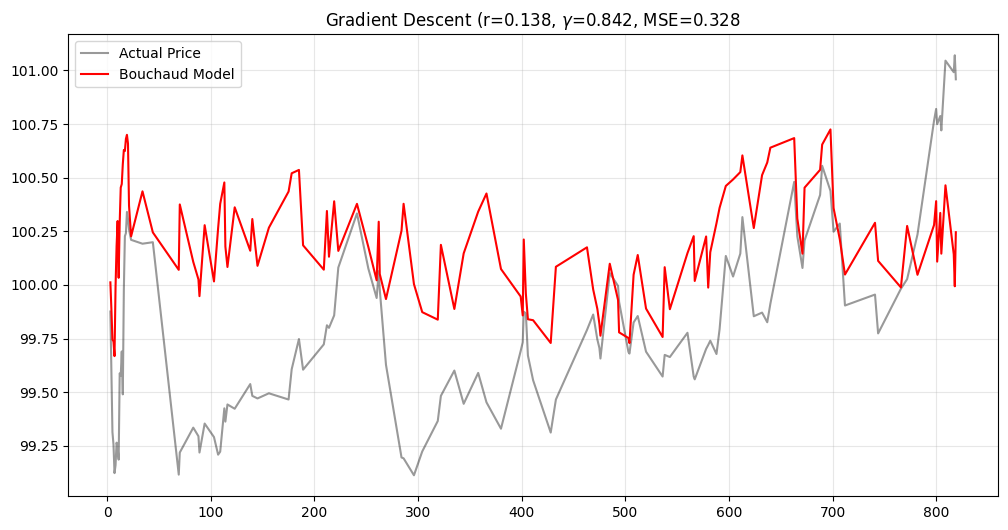

In [93]:
best_r, best_gamma, mse = best_param_no_scale
p0 = df["Price"].iloc[0]
T_max = len(df)

impacts = df["Sign"] * df["Spread"] * (df["Volume"]**best_r)

final_preds = []

for T in range(2, T_max):
    x_t = sum(((T - t)**(-best_gamma)) * impacts.iloc[t] for t in range(1, T))
    final_preds.append(p0 + x_t)

plt.figure(figsize=(12, 6))

plt.plot(df.index[2:T_max], df["Price"].iloc[2:T_max], label="Actual Price", color="black", alpha=0.4)
plt.plot(df.index[2:T_max], final_preds, label="Bouchaud Model", color="red", linewidth=1.5)

plt.title(fr"Gradient Descent (r={best_r:.3f}, $\gamma$={best_gamma:.3f}, MSE={mse:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Using another parameter : the scaling factor $\lambda$

\begin{equation}
\hat{P}^B_i(r;\gamma) = P_0 + \lambda\sum_{s=1}^{i-1} (i - s)^{-\gamma} \varepsilon_s S_s V_s^r
\end{equation}

In [94]:
def get_mse(data, r, gamma, lambdaa):
    pred = []
    price_true = []
    p0 = data["Price"].iloc[0]

    for T in range(2,len(data)):
        impacts = 0
        for t in range(1,T):
            tau = T - t
            impacts += data["Sign"].iloc[t] * data["Spread"].iloc[t] * (data["Volume"].iloc[t]**r) * tau**(-gamma)
        pred.append(p0 + lambdaa * impacts)
        price_true.append(data["Price"].iloc[T])

    return np.mean((np.array(pred)-np.array(price_true))**2)

def get_gradient(data, r, gamma, lambdaa, eps=1e-5):
    current_mse = get_mse(data, r, gamma, lambdaa)
    
    mse_r_plus = get_mse(data, r + eps, gamma, lambdaa)
    grad_r = (mse_r_plus - current_mse) / eps

    mse_g_plus = get_mse(data, r, gamma + eps, lambdaa)
    grad_g = (mse_g_plus - current_mse) / eps

    mse_lambda_plus = get_mse(data, r, gamma, lambdaa + eps)
    grad_lambdaa = (mse_lambda_plus - current_mse) / eps
    
    return grad_r, grad_g, grad_lambdaa

def gradient_descent(data, learning_rate, max_iter,r,gamma, lambdaa):
    best_mse = np.inf
    iter = 0
    best_params = ()

    while iter < max_iter :
        grad_r, grad_gamma, grad_lambdaa = get_gradient(data, r, gamma, lambdaa)

        r = r - learning_rate * grad_r
        gamma = gamma - learning_rate * grad_gamma
        lambdaa = lambdaa - learning_rate * grad_lambdaa

        r = max(0.05, min(0.8, r))
        gamma = max(0.1, min(gamma, 0.9))
        lambdaa = max(1, lambdaa)

        mse = get_mse(data, r, gamma, lambdaa)
        if mse < best_mse:
            best_mse = mse
            best_params = (r, gamma, lambdaa, mse)
        iter += 1
        print(f"{iter} / {max_iter}")

    return best_params

best_param_scale = gradient_descent(df, 0.005, 50, 0.7,0.7, 5)
print(best_param_scale) 
# (data, learning_rate, max_iter, r, gamma, lambda)

results.append({
    "Method": "Gradient Descent + scaling factor ",
    "r": best_param_scale[0],
    "gamma": best_param_scale[1],
    "lambda": best_param_scale[2],
    "MSE": best_param_scale[3]
})

1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50
(0.05, 0.9, 3.951182226278822, 0.601315320738028)


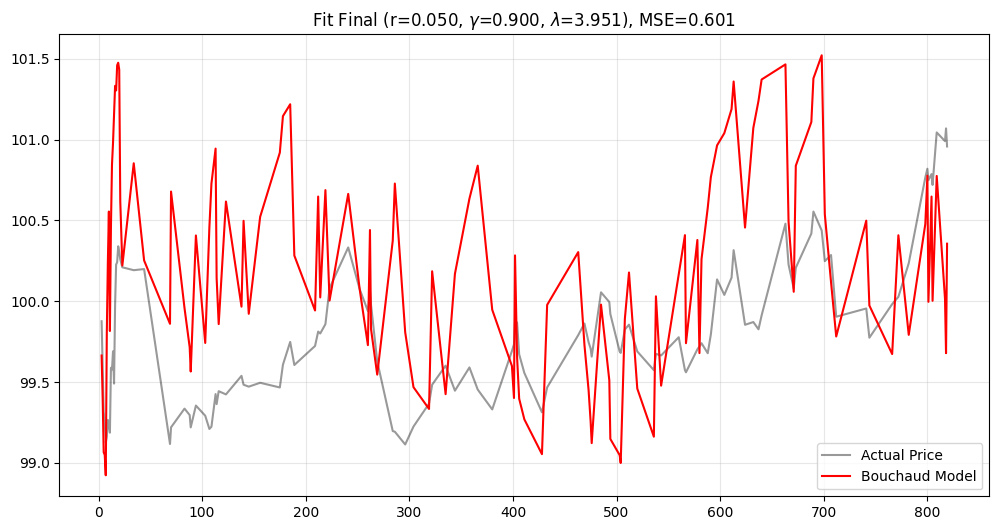

In [ ]:
best_r, best_gamma, best_lambda, mse = best_param_scale
p0 = df["Price"].iloc[0]
T_max = len(df)

impacts = df["Sign"] * df["Spread"] * (df["Volume"]**best_r)

final_preds = []

for T in range(2, T_max):
    x_t = sum(((T - t)**-best_gamma) * impacts.iloc[t] for t in range(1, T))
    final_preds.append(p0 + best_lambda * x_t)

plt.figure(figsize=(12, 6))

plt.plot(df.index[2:T_max], df["Price"].iloc[2:T_max], label="Actual Price", color="black", alpha=0.4)
plt.plot(df.index[2:T_max], final_preds, label="Bouchaud Model", color="red", linewidth=1.5)

plt.title(fr"Fit Final (r={best_r:.3f}, $\gamma$={best_gamma:.3f}, $\lambda$={best_lambda:.3f}), MSE={mse:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Using volatility without scaling factor

\begin{equation}
\hat{P}^B_i(r;\gamma) = P_0 + \sum_{s=1}^{i-1} \sigma_{[s;i-1]}(i - s)^{-\gamma} \varepsilon_s S_s V_s^r
\end{equation}

Where $\sigma_{[s;i-1]}$ is the rolling volatility of the returns between the first instant s and and i-1.

In [96]:
def get_mse(data, r, gamma):
    pred = []
    price_true = []
    p0 = data["Price"].iloc[0]

    for T in range(2,len(data)):
        impacts = 0
        for t in range(1,T):
            tau = T - t
            impacts += data["Sign"].iloc[t] * data["Spread"].iloc[t] * (data["Volume"].iloc[t]**r) * tau**(-gamma)
            
        volatility = data["Price"][:T].std()
        pred.append(p0 + volatility * impacts)
        price_true.append(data["Price"].iloc[T])

    return np.mean((np.array(pred)-np.array(price_true))**2)

def get_gradient(data, r, gamma, eps=1e-5):
    current_mse = get_mse(data, r, gamma)
    
    mse_r_plus = get_mse(data, r + eps, gamma)
    grad_r = (mse_r_plus - current_mse) / eps

    mse_g_plus = get_mse(data, r, gamma + eps)
    grad_g = (mse_g_plus - current_mse) / eps
    
    return grad_r, grad_g

def gradient_descent(data, learning_rate, max_iter,r,gamma):
    best_mse = np.inf
    iter = 0
    best_params = ()

    while iter < max_iter :
        grad_r, grad_gamma = get_gradient(data, r, gamma)

        r = r - learning_rate * grad_r
        gamma = gamma - learning_rate * grad_gamma

        r = max(0.05, min(0.8, r))
        gamma = max(0.1, min(gamma, 0.9))

        mse = get_mse(data, r, gamma)
        if mse < best_mse:
            best_mse = mse
            best_params = (r, gamma, mse)
        iter += 1
        print(f"{iter} / {max_iter}")

    return best_params

best_param_vol = gradient_descent(df, 0.005, 50, 0.5,0.5)
print(best_param_vol) 
# (data, learning_rate, max_iter, r, gamma)

results.append({
    "Method": "Gradient Descent + volatility ",
    "r": best_param_vol[0],
    "gamma": best_param_vol[1],
    "MSE": best_param_vol[2]
})

1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50
(0.28100584145310203, 0.568111735965104, 0.32946871905158714)


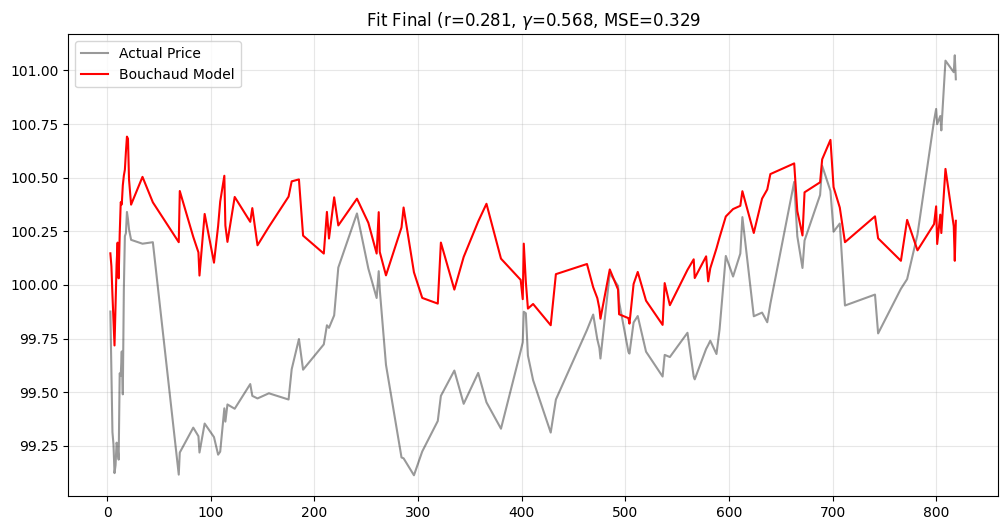

In [97]:
best_r, best_gamma, mse = best_param_vol
p0 = df["Price"].iloc[0]
T_max = len(df)

impacts = df["Sign"] * df["Spread"] * (df["Volume"]**best_r)

final_preds = []

for T in range(2, T_max):
    x_t = sum(((T - t)**-best_gamma) * impacts.iloc[t] for t in range(1, T))
    vol = df["Price"][:T].std()
    final_preds.append(p0 + vol * x_t)

plt.figure(figsize=(12, 6))

plt.plot(df.index[2:T_max], df["Price"].iloc[2:T_max], label="Actual Price", color="black", alpha=0.4)
plt.plot(df.index[2:T_max], final_preds, label="Bouchaud Model", color="red", linewidth=1.5)

plt.title(fr"Fit Final (r={best_r:.3f}, $\gamma$={best_gamma:.3f}, MSE={mse:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [98]:
df_result = pd.DataFrame(results)

print(df_result)

                               Method         r     gamma       MSE    lambda
0                         Grid_Search  0.100000  0.850000  0.365018       NaN
1                   Gradient Descent   0.138234  0.841573  0.328017       NaN
2  Gradient Descent + scaling factor   0.050000  0.900000  0.601315  3.951182
3      Gradient Descent + volatility   0.281006  0.568112  0.329469       NaN


# Question E (Q2 and Q3 of TD5)

In [149]:
gbp_eur=pd.read_excel("Dataset_TD5.xlsx",sheet_name="GBPEUR Curncy")
sek_eur=pd.read_excel("Dataset_TD5.xlsx",sheet_name="SEKEUR Curncy")
cad_eur=pd.read_excel("Dataset_TD5.xlsx",sheet_name="CADEUR Curncy")

gbp_eur['PRICE'] = (gbp_eur["HIGH"] + gbp_eur["LOW"]) / 2
sek_eur['PRICE'] = (sek_eur["HIGH"] + sek_eur["LOW"]) / 2
cad_eur['PRICE'] = (cad_eur["HIGH"] + cad_eur["LOW"]) / 2

print(gbp_eur.isna().sum())
print(sek_eur.isna().sum())
print(cad_eur.isna().sum())

Date     0
HIGH     0
LOW      0
PRICE    0
dtype: int64
Date     0
HIGH     0
LOW      0
PRICE    0
dtype: int64
Date     0
HIGH     0
LOW      0
PRICE    0
dtype: int64


In [ ]:
gbp_eur["RETURN"] = gbp_eur['PRICE'].pct_change()
sek_eur["RETURN"] = sek_eur['PRICE'].pct_change()
cad_eur["RETURN"] = cad_eur['PRICE'].pct_change()


gbp_eur = gbp_eur.dropna().reset_index(drop=True)
sek_eur = sek_eur.dropna().reset_index(drop=True)
cad_eur = cad_eur.dropna().reset_index(drop=True)

print(gbp_eur.isna().sum())
print(sek_eur.isna().sum())
print(cad_eur.isna().sum())

Date      0
HIGH      0
LOW       0
PRICE     0
RETURN    0
dtype: int64
Date      0
HIGH      0
LOW       0
PRICE     0
RETURN    0
dtype: int64
Date      0
HIGH      0
LOW       0
PRICE     0
RETURN    0
dtype: int64


,Date,HIGH,LOW,PRICE,RETURN
0,2016-03-07 09:15:00,1.2940,1.2930,1.29350,0.000812
1,2016-03-07 09:30:00,1.2943,1.2922,1.29325,-0.000193
2,2016-03-07 09:45:00,1.2930,1.2913,1.29215,-0.000851
3,2016-03-07 10:00:00,1.2931,1.2921,1.29260,0.000348
4,2016-03-07 10:15:00,1.2926,1.2921,1.29235,-0.000193


#### a – With Haar wavelets and the dataset provided with TD5, determine the multiresolution correlation between all the pairs of FX rates, using GBPEUR, SEKEUR, and CADEUR (work with the average between the highest and the lowest price and transform this average price in returns on the smallest time step).   
#### Do you observe an Epps effect and how could you explain this?


In [112]:
n = len(gbp_eur)
size_max_window = 2**9 #number of the maximal window size because if we have 12929 rows we can do max 1 window of 12929//2**13 = 8192 values and 12929-8192 = 4737 are 
nb_max_window = n // size_max_window
n_truncated = nb_max_window * size_max_window

returns_gbp_eur = gbp_eur['RETURN'].iloc[-n_truncated:].values
returns_sek_eur = sek_eur['RETURN'].iloc[-n_truncated:].values
returns_cad_eur = cad_eur['RETURN'].iloc[-n_truncated:].values

The correlation is defined by :
$$\rho(X,Y) = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}$$

In [140]:
def correlation(list1, list2):
    if len(list1) != len(list2):
        return None
    
    n = len(list1)
    m1 = sum(list1) / n
    m2 = sum(list2) / n
    numerator = 0
    s_squared_1 = 0
    s_squared_2 = 0
    
    for i in range(n):
        diff1 = list1[i] - m1
        diff2 = list2[i] - m2
        
        numerator += diff1 * diff2
        s_squared_1 += diff1 ** 2
        s_squared_2 += diff2 ** 2

    denominator = (s_squared_1 * s_squared_2) ** 0.5
    
    if denominator == 0:
        return 0
        
    return numerator / denominator

Haar transfrom :
$$
\psi(t) =
\begin{cases}
1 & \text{if } 0 \leq t < \frac{1}{2} \\
-1 & \text{if } \frac{1}{2} \leq t < 1 \\
0 & \text{otherwise}
\end{cases}
$$

Scaling function :
$$
\phi_{j,k}(t) = 2^{j/2}\psi(2^j t - k)
$$

In [ ]:
def haar_transfrom(window_returns, size_window):
    coef = 0
    for t in range(size_window):
        if t < size_window // 2:

            coef += window_returns[t]
        else:
            coef -= window_returns[t]

    return coef

def wavelet_coefficients_non_overlapping(returns, j):
    size_window = 2**j
    nb_window = len(returns) // size_window

    coefficients = []

    for i in range(nb_window):
        window = returns[i * size_window: (i+1)*size_window]
        coef = haar_transfrom(window, size_window)
        coefficients.append(coef)

    return np.array(coefficients) * size_window**0.5

def wavelet_coefficients_overlapping(returns, j):
    size_window = 2**j    

    coefficients = []
    for i in range(len(returns) - size_window + 1):
        window = returns[i : i + size_window]
        coef = haar_transfrom(window, size_window)
        coefficients.append(coef)
    
    return np.array(coefficients) * size_window**0.5

def correlation_matrix_at_level(list_wave_coef):
    matrix_size = len(list_wave_coef)
    correlation_matrix = np.zeros((matrix_size, matrix_size))

    for i in range(matrix_size):
        for j in range(i, matrix_size):
            if i == j:
                correlation_matrix[i, j] = 1
            else:
                corr = correlation(list_wave_coef[i], list_wave_coef[j])
                correlation_matrix[i, j] = correlation_matrix[j, i] = corr

    return correlation_matrix


In [138]:
levels = [j for j in range(1,10)]

pair_gbp_sek_non_overlapping = []
pair_gbp_cad_non_overlapping = []
pair_sek_cad_non_overlapping = []

pair_gbp_sek_overlapping = []
pair_gbp_cad_overlapping = []
pair_sek_cad_overlapping = []

for j in levels:    
    gbpeur_haar = wavelet_coefficients_non_overlapping(returns_gbp_eur, j)
    sekeur_haar = wavelet_coefficients_non_overlapping(returns_sek_eur, j)
    cadeur_haar = wavelet_coefficients_non_overlapping(returns_cad_eur, j)
    haar_transforms = [gbpeur_haar, sekeur_haar, cadeur_haar]
    mat = correlation_matrix_at_level(haar_transforms)
    pair_gbp_sek_non_overlapping.append(mat[0, 1])
    pair_gbp_cad_non_overlapping.append(mat[0, 2])
    pair_sek_cad_non_overlapping.append(mat[1, 2])

    gbpeur_haar = wavelet_coefficients_overlapping(returns_gbp_eur, j)
    sekeur_haar = wavelet_coefficients_overlapping(returns_sek_eur, j)
    cadeur_haar = wavelet_coefficients_overlapping(returns_cad_eur, j)
    haar_transforms = [gbpeur_haar, sekeur_haar, cadeur_haar]
    mat = correlation_matrix_at_level(haar_transforms)
    pair_gbp_sek_overlapping.append(mat[0, 1])
    pair_gbp_cad_overlapping.append(mat[0, 2])
    pair_sek_cad_overlapping.append(mat[1, 2])

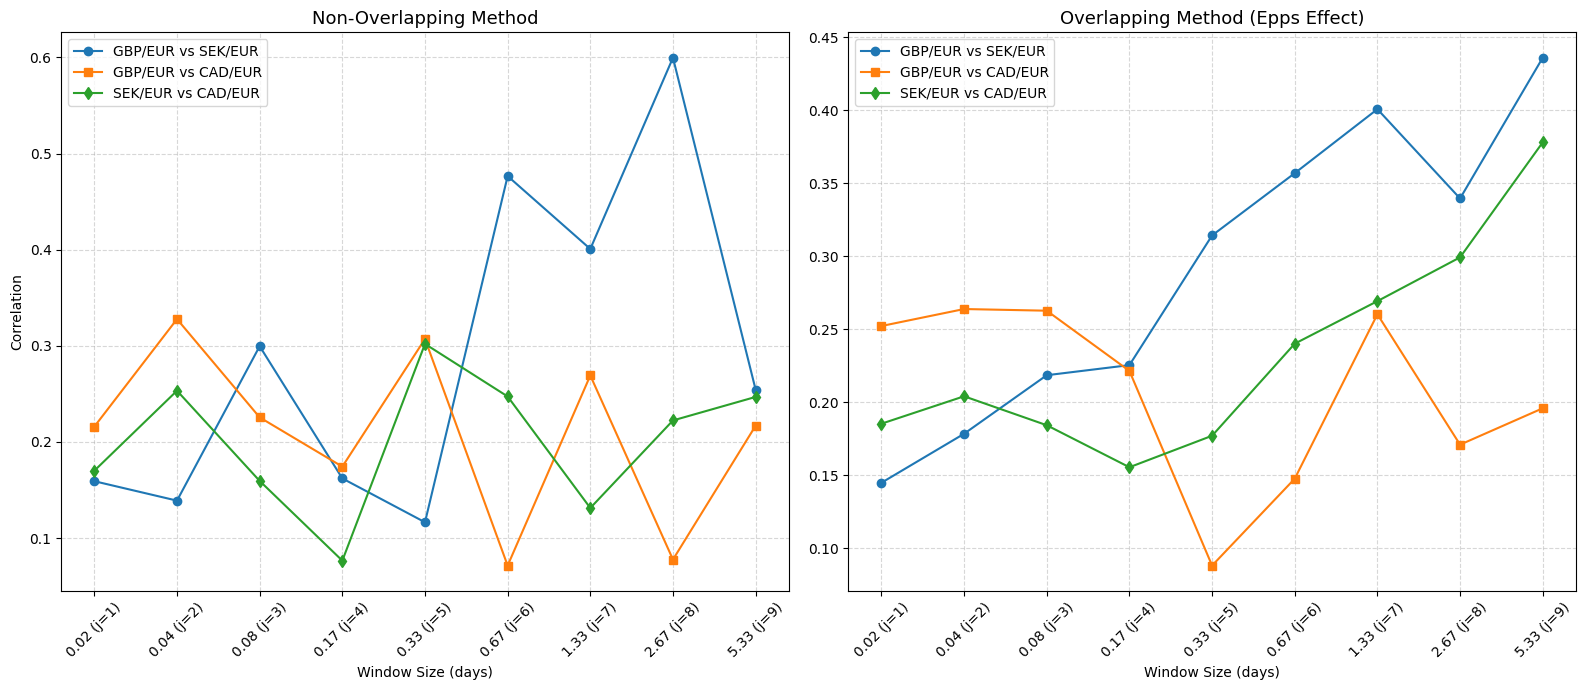

In [148]:
x_values = [(2**j * 15) / (24*60) for j in levels] 

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.plot(x_values, pair_gbp_sek_non_overlapping, marker='o', label='GBP/EUR vs SEK/EUR')
plt.plot(x_values, pair_gbp_cad_non_overlapping, marker='s', label='GBP/EUR vs CAD/EUR')
plt.plot(x_values, pair_sek_cad_non_overlapping, marker='d', label='SEK/EUR vs CAD/EUR')

plt.xscale('log', base=2)
plt.title("Non-Overlapping Method", fontsize=13)
plt.xlabel("Window Size (days)")
plt.ylabel("Correlation")

plt.xticks(x_values, [f"{v:.2f} (j={j})" for v, j in zip(x_values, levels)], rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(x_values, pair_gbp_sek_overlapping, marker='o', label='GBP/EUR vs SEK/EUR')
plt.plot(x_values, pair_gbp_cad_overlapping, marker='s', label='GBP/EUR vs CAD/EUR')
plt.plot(x_values, pair_sek_cad_overlapping, marker='d', label='SEK/EUR vs CAD/EUR')

plt.xscale('log', base=2)
plt.title("Overlapping Method (Epps Effect)", fontsize=13)
plt.xlabel("Window Size (days)")

plt.xticks(x_values, [f"{v:.2f} (j={j})" for v, j in zip(x_values, levels)], rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### b – Calculate the Hurst exponent of GBPEUR, SEKEUR, and CADEUR. Determine their annualized volatility using the daily volatility and Hurst exponents.

In [179]:
gbp_eur=pd.read_excel("Dataset_TD5.xlsx",sheet_name="GBPEUR Curncy")
sek_eur=pd.read_excel("Dataset_TD5.xlsx",sheet_name="SEKEUR Curncy")
cad_eur=pd.read_excel("Dataset_TD5.xlsx",sheet_name="CADEUR Curncy")

gbp_eur['PRICE'] = (gbp_eur["HIGH"] + gbp_eur["LOW"]) / 2
sek_eur['PRICE'] = (sek_eur["HIGH"] + sek_eur["LOW"]) / 2
cad_eur['PRICE'] = (cad_eur["HIGH"] + cad_eur["LOW"]) / 2

gbp_eur['RETURN'] = gbp_eur["PRICE"].pct_change()
sek_eur['RETURN'] = sek_eur["PRICE"].pct_change()
cad_eur['RETURN'] = cad_eur["PRICE"].pct_change()

We know that to approximate the Hurst exponent, we can use the following formula :

$$ \hat{H} = \frac{1}{2} \log_2 \left( \frac{M_2'}{M_2} \right) $$

where :

$$ M_2' = \frac{2}{NT} \sum_{i=1}^{NT/2} \left| X\left(\frac{2i}{N}\right) - X\left(\frac{2(i-1)}{N}\right) \right|^2 $$

and :

$$ M_2 = \frac{1}{NT} \sum_{i=1}^{NT} \left| X\left(\frac{i}{N}\right) - X\left(\frac{i-1}{N}\right) \right|^2 $$




In [180]:
def hurst_exponent_estimation(X):
    M_2 = 0
    M_2_prime = 0
    N = len(X)

    for i in range(1,N) :
        M_2 += (X.iloc[i] - X.iloc[i-1])**2

    M_2 = M_2 * (1/N)

    for i in range(1,N // 2) :
        M_2_prime += (X.iloc[2*i] - X.iloc[2*(i-1)])**2

    M_2_prime = M_2_prime * (2/N)

    if M_2_prime == 0:
            print("Erreur: Le dénominateur M_2_prime est zéro.")
            return np.nan

    return 0.5*np.log2(M_2_prime / M_2)

Hurst_GBPEUR = hurst_exponent_estimation(gbp_eur["PRICE"])
Hurst_SEKEUR = hurst_exponent_estimation(sek_eur["PRICE"])
Hurst_CADEUR = hurst_exponent_estimation(cad_eur["PRICE"])

print(f"-Hurst exponent estimated for GBP/EUR :{Hurst_GBPEUR}")
print(f"-Hurst exponent estimated for SEK/EUR :{Hurst_SEKEUR}")
print(f"-Hurst exponent estimated for CAD/EUR :{Hurst_CADEUR}")

-Hurst exponent estimated for GBP/EUR :0.6713731707231525
-Hurst exponent estimated for SEK/EUR :0.6545913434209861
-Hurst exponent estimated for CAD/EUR :0.6552402726566733


Based on our estimated Hurst exponents ($\hat{H}_{GBP/EUR} \approx 0.6714$, $\hat{H}_{SEK/EUR} \approx 0.6546$, and $\hat{H}_{CAD/EUR} \approx 0.6552$), we can conclude that the returns are not independent since $H \neq \frac{1}{2}$. 

Specifically:
* **Persistence**: Since $H > \frac{1}{2}$, returns are positively correlated, indicating long-memory behavior.
* **Non-Linear Scaling**: Rather than using the standard square root of time rule (which assumes $H = 0.5$), we scale the volatility using the Hurst exponent:

$$\sigma_{annual} = \sigma_{\ 15min} \cdot (252 \times 8.5 \times 4)^{\hat{H}}$$

where :

- H : Hurst exponent
- 252 : number of trading days in a year  
- 8.5h : hours where the market is open in a trading day 
- 4 : periods of 15 minutes in one hour

In [181]:
def annualized_volatility(returns, hurst_exponent=False):
    if hurst_exponent:
        return returns.std() *(252 * 8.5 * 4) ** hurst_exponent
    else:
        return returns.std() *(252 * 8.5 * 4) ** 0.5

annualy_vol_GBPEUR = annualized_volatility(gbp_eur["RETURN"],Hurst_GBPEUR)
print(f"Annualized volatility for GBPEUR: {annualy_vol_GBPEUR:.6f} with Hurst exponent")

annualy_vol_SEKPEUR = annualized_volatility(sek_eur["RETURN"],Hurst_SEKEUR)
print(f"Annualized volatility for SEKEUR: {annualy_vol_SEKPEUR:.6f} with Hurst exponent")

annualy_vol_CADPEUR = annualized_volatility(cad_eur["RETURN"],Hurst_CADEUR)
print(f"Annualized volatility for CADEUR: {annualy_vol_CADPEUR:.6f} with Hurst exponent")


annualy_vol_GBPEUR = annualized_volatility(gbp_eur["RETURN"])
print(f"\nAnnualized volatility for GBPEUR: {annualy_vol_GBPEUR:.6f} without Hurst exponent")

annualy_vol_SEKPEUR = annualized_volatility(sek_eur["RETURN"])
print(f"Annualized volatility for SEKEUR: {annualy_vol_SEKPEUR:.6f} without Hurst exponent")

annualy_vol_CADPEUR = annualized_volatility(cad_eur["RETURN"])
print(f"Annualized volatility for CADEUR: {annualy_vol_CADPEUR:.6f} without Hurst exponent")

Annualized volatility for GBPEUR: 0.272338 with Hurst exponent
Annualized volatility for SEKEUR: 0.122786 with Hurst exponent
Annualized volatility for CADEUR: 0.191148 with Hurst exponent

Annualized volatility for GBPEUR: 0.057692 without Hurst exponent
Annualized volatility for SEKEUR: 0.030280 without Hurst exponent
Annualized volatility for CADEUR: 0.046863 without Hurst exponent
